In [34]:
from __future__ import print_function
import numpy as np 
import pandas as pd

In [35]:
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import fix_yahoo_finance as yf
yf.pdr_override()
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

In [36]:
from datetime import datetime as dt, timedelta
import time
import matplotlib.pyplot as plt
import math

In [37]:
import numpy as np
from __future__ import absolute_import
#Anything from keras
import os
os.environ['KERAS_BACKEND']='tensorflow'

In [38]:
from tensorflow.python.keras import utils

In [39]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [40]:
# to not display the warnings of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# set random seed for reproducibility
np.random.seed(123)

## Download data for Symbol ##

In [41]:
ticker = "AAPL"
start = dt.today() - timedelta(days=5*365)
end = dt.now()

df = web.DataReader(ticker, 'iex', start, end)

# convert index to datetime
df.index = pd.to_datetime(df.index)

5y


In [42]:
#Convert close price to float and reshapre to column vector 

# save stock close as float
stock_prices = df.close.values.astype('float32')

# reshape to column vector
stock_prices = stock_prices.reshape(len(stock_prices), 1)

Calculate train / test size (70/30 split)

In [43]:
train_size = int(len(stock_prices) * 0.7)
test_size = len(stock_prices) - train_size

normalize the data using sklearn scaler

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(stock_prices)

# save scaled close price for review/visualization
df['scaled_close'] = stock_prices

Train / Test Split on Scaled Data

In [45]:
train, test = stock_prices[0:train_size,:], stock_prices[train_size:len(stock_prices),:]

print('Number of training samples/ test samples:', len(train), len(test))

Number of training samples/ test samples: 880 378


Function to convert an array of values into a time series dataset

result after function call

In [46]:
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert Apple's stock price data into time series dataset
X_train, y_train = create_dataset(train, 7)
X_test, y_test = create_dataset(test, 7)

Reshape input of the LSTM to be format [samples, time steps, features]

In [47]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Create and Fit the LSTM Network ##

In [48]:
model = Sequential()
model.add(LSTM(4, input_shape=(7, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=3)

Epoch 1/100
872/872 [==============================] - 2s 3ms/step - loss: 0.0412
Epoch 2/100
872/872 [==============================] - 2s 2ms/step - loss: 0.0093
Epoch 3/100
872/872 [==============================] - 2s 2ms/step - loss: 0.0029
Epoch 4/100
872/872 [==============================] - 2s 2ms/step - loss: 5.4014e-04
Epoch 5/100
872/872 [==============================] - 2s 2ms/step - loss: 3.3543e-04
Epoch 6/100
872/872 [==============================] - 2s 2ms/step - loss: 3.2648e-04
Epoch 7/100
872/872 [==============================] - 2s 2ms/step - loss: 3.1455e-04
Epoch 8/100
872/872 [==============================] - 1s 2ms/step - loss: 3.0388e-04
Epoch 9/100
872/872 [==============================] - 2s 2ms/step - loss: 2.9778e-04
Epoch 10/100
872/872 [==============================] - 2s 2ms/step - loss: 2.9101e-04
Epoch 11/100
872/872 [==============================] - 2s 2ms/step - loss: 2.8274e-04
Epoch 12/100
872/872 [==============================] - 2s 2ms/s

872/872 [==============================] - 2s 2ms/step - loss: 1.0703e-04
Epoch 96/100
872/872 [==============================] - 1s 2ms/step - loss: 1.0558e-04
Epoch 97/100
872/872 [==============================] - 1s 2ms/step - loss: 1.0703e-04
Epoch 98/100
872/872 [==============================] - 1s 2ms/step - loss: 1.0559e-04
Epoch 99/100
872/872 [==============================] - 1s 2ms/step - loss: 1.0741e-04
Epoch 100/100
872/872 [==============================] - 2s 2ms/step - loss: 1.0944e-04


## Make predictions ##

In [49]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

Unscale predictions and targets

In [50]:
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

Calculate root mean squared error

In [51]:
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.48 RMSE
Test Score: 9.69 RMSE


Create dataframe for visualization

In [52]:
# get the test data from web dataset# get th 
df_plot = df.iloc[len(df) - len(testPredict):len(df),:]

In [53]:
# setup date column
df_plot['date'] = df_plot.index
df_plot.reset_index(drop=True, inplace=True)

# add the predictions in
df_plot['prediction'] = pd.DataFrame(testPredict)
df_plot['date'] = pd.to_datetime(df_plot['date'])

# reset index
df_plot.set_index('date', inplace=True)

## Plot Stock Price prediction ##

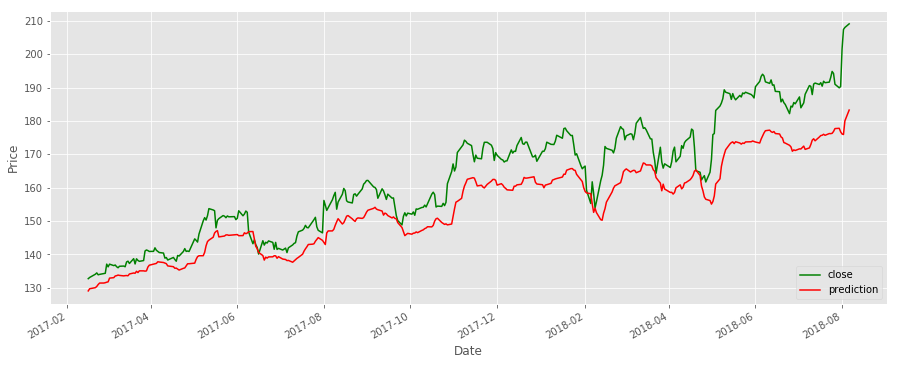

In [54]:
df_plot['close'].plot(figsize=(15,6), color="green")
df_plot['prediction'].plot(figsize=(15,6), color="red")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Second Clustering Algorithm Attempt #

In [55]:
import sys
print(sys.version)
from matplotlib import pyplot as plt
import pandas as pd
import datetime
import numpy as np

3.5.5 |Anaconda custom (64-bit)| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]


In [56]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
yf.pdr_override()
import numpy as np
import datetime

In [57]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [58]:
import os
os.chdir('C:\\Users\ObsidianQuantitative\Desktop')

In [59]:
data = pd.read_csv('spx_vix.csv')
print(data.shape)
data.head()

(1510, 3)


,Date,vx,Close
0,8/7/2012,15.99,1401.35
1,8/8/2012,15.32,1402.22
2,8/9/2012,15.28,1402.80
3,8/10/2012,14.74,1405.87
4,8/13/2012,13.70,1404.11


In [60]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

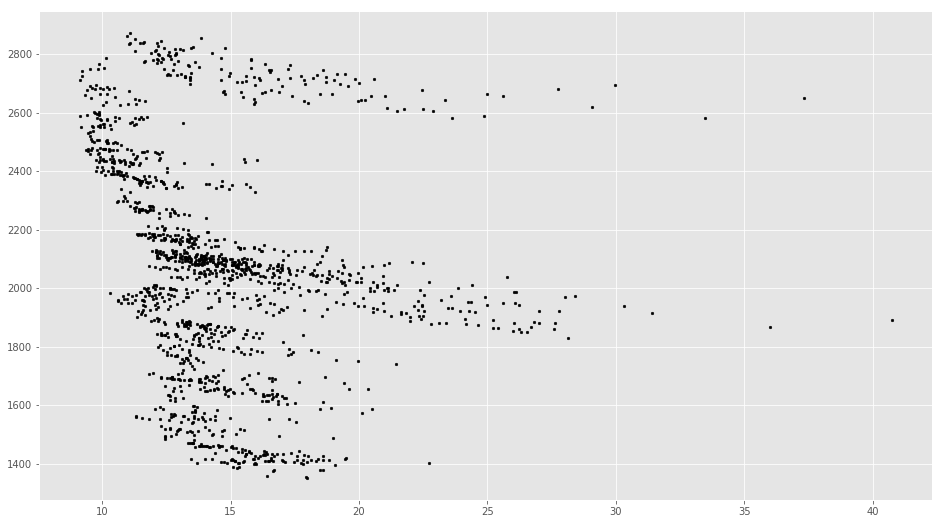

In [61]:
# Getting the values and plotting it
f1 = data['vx'].values
f2 = data['Close'].values
X = np.array(list(zip(f1, f2)))
plt.scatter(f1, f2, c='black', s=7)

In [62]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [63]:
# Number of clusters
k = 3
# X coordinates of random centroids
C_x = np.random.randint(0, np.max(X)-20, size=k)
# Y coordinates of random centroids
C_y = np.random.randint(0, np.max(X)-20, size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
print(C)

[[1017.   80.]
 [1972. 1757.]
 [1184.  878.]]


In [64]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

In [65]:
# Comparing with scikit-learn centroids
print(C) # From Scratch
print(centroids) # From sci-kit learn

[[1017.   80.]
 [1972. 1757.]
 [1184.  878.]]
[[  12.92090426 2574.6775266 ]
 [  14.93297753 1581.49      ]
 [  15.36748072 2039.22470437]]


In [66]:
#create new dataset using make_blobs function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = (16, 9)

# Creating a sample dataset with 4 clusters
X, y = make_blobs(n_samples=800, n_features=3, centers=4)

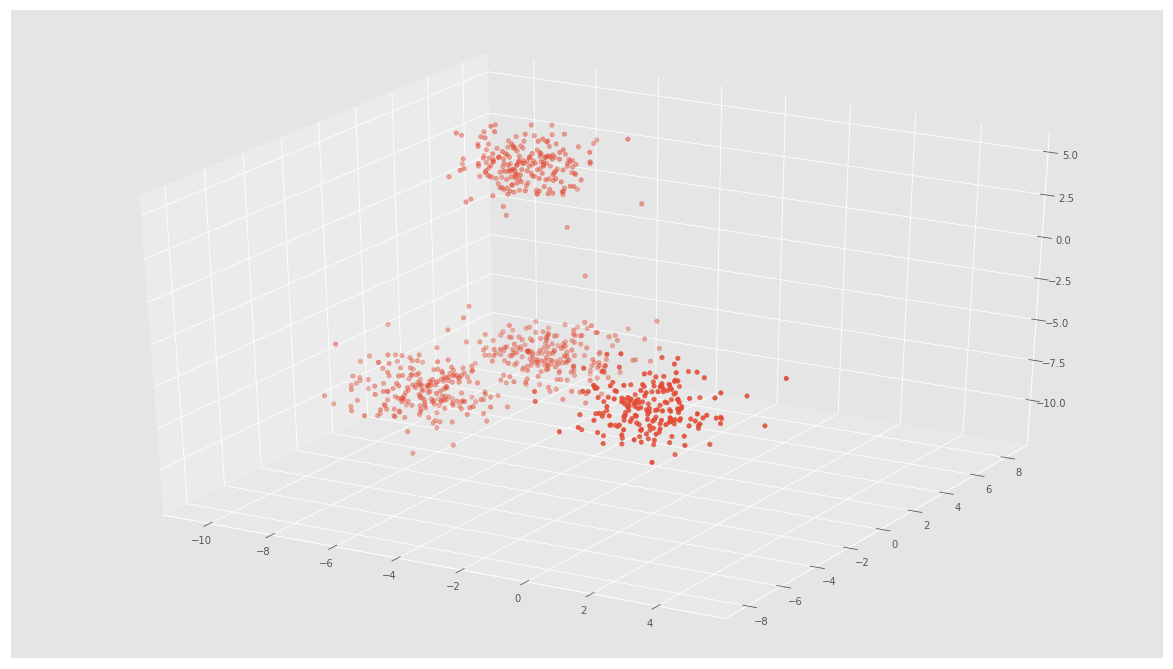

In [67]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

In [68]:
# Initializing KMeans
kmeans = KMeans(n_clusters=4)
# Fitting with inputs
kmeans = kmeans.fit(X)
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_

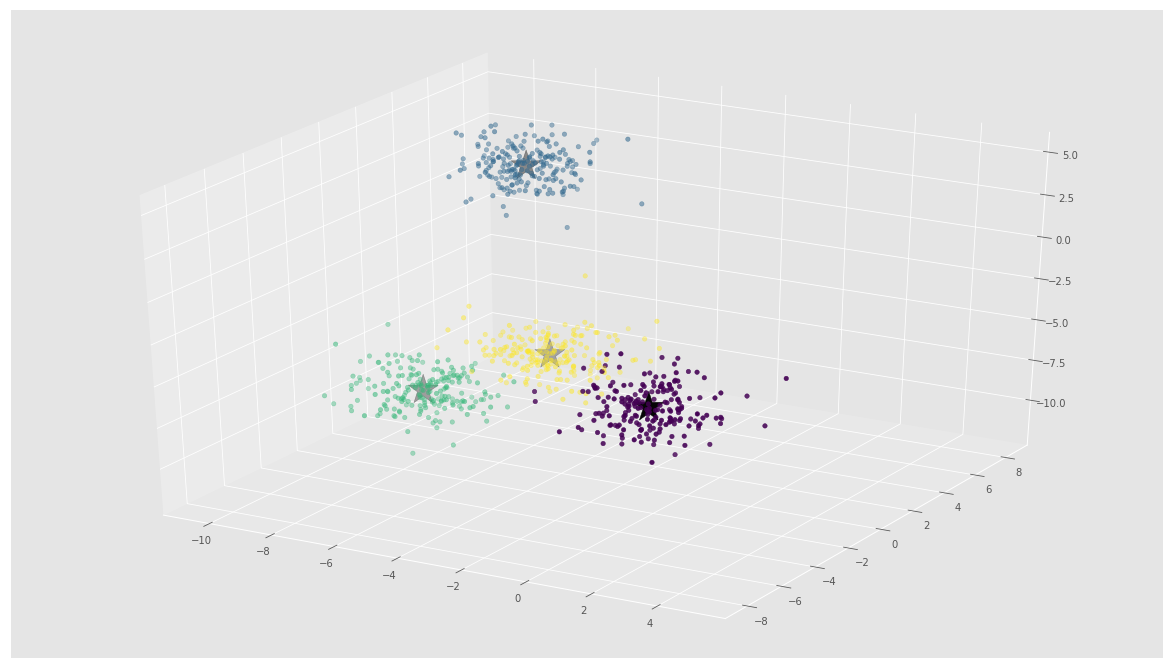

In [69]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='#050505', s=1000)